<a href="https://colab.research.google.com/github/IlyaZelinskiy/Wav2vec_CFT_SHIFT_LAB/blob/main/ASR_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==4.11.3
!pip install datasets
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from transformers import Wav2Vec2ForCTC
import pandas as pd
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import IPython
from IPython.display import Audio, display

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#перед сохранением удалить
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string

In [3]:

def map_to_emb(batch):
    audio_batch = batch["audio"] 
    # [{..., "array": np.array([...]), ...}, ..., {..., "array": np.array([...]), ...}], length == batch_size
    arrays = list(map(lambda x: x["array"], audio_batch))
    # [np.array([...]), ..., np.array([...])]
    input_values = processor(arrays, return_tensors="pt", padding="longest", sampling_rate=16000).input_values
    with torch.no_grad():
        unit_embeddings = model(input_values.to(device), output_hidden_states = True).hidden_states

    embeddings = list(unit_embeddings[-1].mean(axis=1))
    batch["embedding"] = embeddings
    return batch

In [4]:
def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line


In [5]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# SLUE

In [6]:
slue = load_dataset("asapp/slue", "voxpopuli")

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
slue

DatasetDict({
    train: Dataset({
        features: ['id', 'audio', 'speaker_id', 'normalized_text', 'raw_text', 'raw_ner', 'normalized_ner', 'raw_combined_ner', 'normalized_combined_ner'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['id', 'audio', 'speaker_id', 'normalized_text', 'raw_text', 'raw_ner', 'normalized_ner', 'raw_combined_ner', 'normalized_combined_ner'],
        num_rows: 1753
    })
    test: Dataset({
        features: ['id', 'audio', 'speaker_id', 'normalized_text', 'raw_text', 'raw_ner', 'normalized_ner', 'raw_combined_ner', 'normalized_combined_ner'],
        num_rows: 1842
    })
})

In [6]:
slue['train']['audio'][1]['array']

array([ 0.00132601,  0.00058881, -0.00052187, ...,  0.06857217,
        0.07835516,  0.07845446], dtype=float32)

In [7]:
slue['train']['normalized_text'][1]

'two thousand and twelve for instance the new brussels i regulation provides for the right for employees to sue several employers together and the right for employees to have access to courts in europe even if the employer is domiciled outside europe. the commission will'

In [10]:
len(slue['train']['normalized_text'])

5000

In [8]:
slue['train']['raw_text'][1]

'2012. For instance, the new Brussels I Regulation provides for the right for employees to sue several employers together and the right for employees to have access to courts in Europe, even if the employer is domiciled outside Europe. The Commission will'

In [9]:
import IPython.display as ipd
import numpy as np


print(slue['train']['normalized_text'][1])
ipd.Audio(data=np.asarray(slue['train']['audio'][1]['array']), autoplay=False, rate=16000) 

two thousand and twelve for instance the new brussels i regulation provides for the right for employees to sue several employers together and the right for employees to have access to courts in europe even if the employer is domiciled outside europe. the commission will


In [7]:
all_text = slue['train']['normalized_text']
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing)
tfidf_slue = tfidf_vectorizer.fit_transform(all_text)
embeddings_slue = slue['train'].map(map_to_emb, batched=True, batch_size=1)

In [17]:
embeddings_slue.shape

(5000, 10)

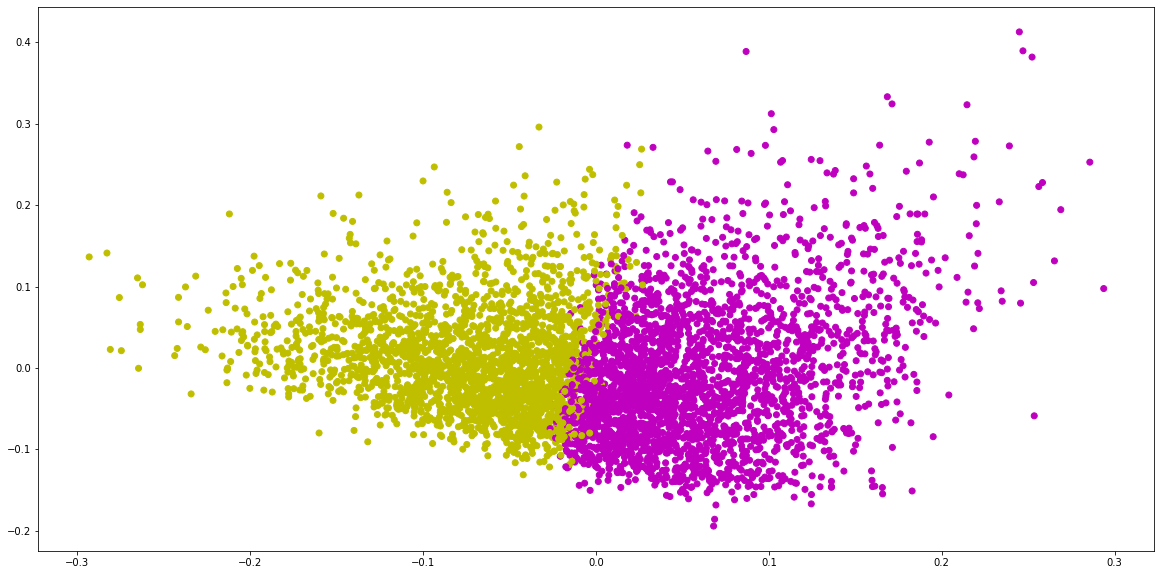

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(tfidf_slue)
kmean_indices = kmeans.fit_predict(tfidf_slue)
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(tfidf_slue.toarray())
colors = ["y", "m" ]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])

In [9]:
array_num_tfidf_emb = []
for i in range(len(all_text)):
    lines_for_predicting = [all_text[i]]
    array_num_tfidf_emb.append(kmeans.predict(tfidf_vectorizer.transform(lines_for_predicting)))

In [10]:
clus_zero = []
clus_one = []
for i in range(len(all_text)):
    if array_num_tfidf_emb[i][0] == 1:
        clus_one.append(i)
    else:
        clus_zero.append(i)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.005s...
[t-SNE] Computed neighbors for 5000 samples in 1.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.254968
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.820610
[t-SNE] KL divergence after 1000 iterations: 2.297626


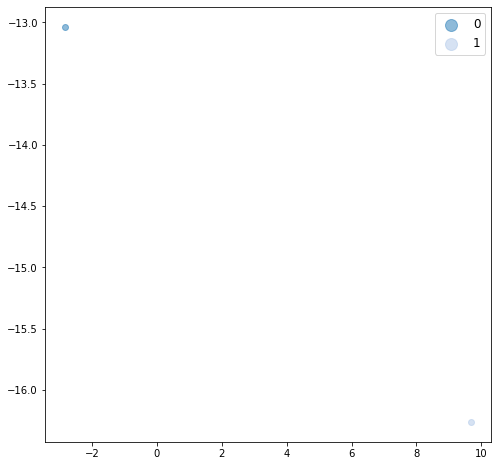

In [11]:
from sklearn.manifold import TSNE
from matplotlib import cm

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(embeddings_slue['embedding'])
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 2
for lab in range(num_categories):
    # indices = test_predictions==lab
    indices = lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()


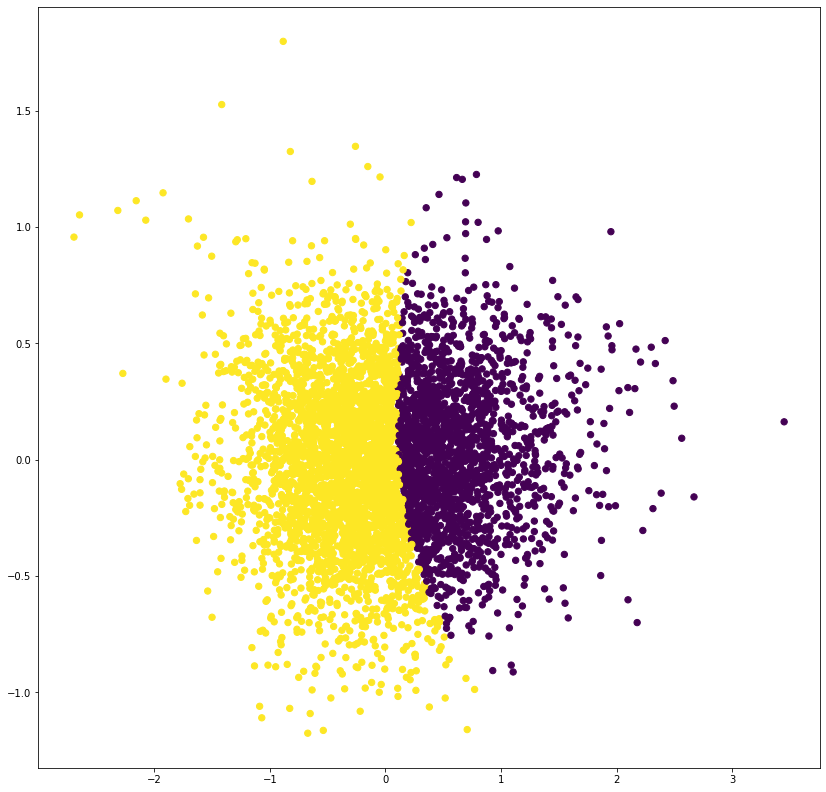

In [12]:

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

embeddings_2d = PCA(n_components=2, random_state=0).fit_transform(embeddings_slue['embedding'])
embeddings_2d
n_clusters = 2
gm = GaussianMixture(n_components=n_clusters).fit(embeddings_2d)
clusters = gm.predict(embeddings_2d)

plt.figure(figsize=(14, 14))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=40, c=clusters)
plt.show()

In [13]:
clus_0 = np.argwhere(clusters == 0)#значения текстов в списке dataset входящих в кластер 0
clus_1 = np.argwhere(clusters == 1)#значения текстов в списке dataset входящих в кластер 1

In [32]:
clus_1

array([[   0],
       [   1],
       [   2],
       ...,
       [4997],
       [4998],
       [4999]])

In [15]:
embeddings_slue

Dataset({
    features: ['id', 'audio', 'speaker_id', 'normalized_text', 'raw_text', 'raw_ner', 'normalized_ner', 'raw_combined_ner', 'normalized_combined_ner', 'embedding'],
    num_rows: 5000
})

In [17]:
with open('slue_emb_tfidf.npy', 'wb') as f:
    np.save(f, tfidf_slue.toarray())
    np.save(f, embeddings_slue['embedding'])
    np.save(f, clus_one)#номера текстов входящих в кластер 1 для эмб tfidf
    np.save(f, clus_zero)#номера текстов входящих в кластер 0 для эмб tfidf 
    np.save(f, clus_0)#номера текстов входящих в кластер 0 для эмбединга аудио
    np.save(f, clus_1)#номера текстов входящих в кластер 1



In [19]:
with open('slue_emb_tfidf.npy', 'rb') as f:
        a=np.load(f)
        b=np.load(f)
        c=np.load(f)#номера текстов входящих в кластер 1 для эмб tfidf
        d=np.load(f)#номера текстов входящих в кластер 0 для эмб tfidf 
        g=np.load(f)#номера текстов входящих в кластер 0 для эмбединга аудио
        e=np.load(f)#номера текстов входящих в кластер 1

# minds14

In [ ]:
minds14 = load_dataset("PolyAI/minds14", 'en-AU')#вроде как это датасет состоящий из записей разговоров в банке

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset minds14 downloaded and prepared to /root/.cache/huggingface/datasets/PolyAI___minds14/en-AU/1.0.0/aa40414f15e0f919231d617440192034af844835dc1e6a697f4b552e0551fd26. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
minds14

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 654
    })
})

In [ ]:
minds14['train']['transcription'][1]

'hello I like to pay for Bill I would actually like to make a payment but yeah could you help me'

In [ ]:
minds14['train']['audio'][1]['array']

array([0.00024414, 0.        , 0.        , ..., 0.12487793, 0.10339355,
       0.03210449], dtype=float32)

In [ ]:
import IPython.display as ipd
import numpy as np


print(minds14['train']['transcription'][1])
ipd.Audio(data=np.asarray(minds14['train']['audio'][1]['array']), autoplay=False, rate=8000) 

hello I like to pay for Bill I would actually like to make a payment but yeah could you help me


# OpensLR

In [ ]:
openslr70 = load_dataset("openslr", "SLR70") #nigerian english
#openslr83 = load_dataset("openslr", "SLR83") #SLR83 UK and Ireland

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/760M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/454M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

Dataset open_slr downloaded and prepared to /root/.cache/huggingface/datasets/open_slr/SLR70/0.0.0/e0fb9e36094eff565efe812d1aba158f6a46ce834cb9705c91d1e2d6ba78ed31. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
openslr70


DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'sentence'],
        num_rows: 3359
    })
})

In [ ]:
openslr70['train']['audio'][0]['array']

array([-1.2207031e-04, -1.2207031e-04, -1.2207031e-04, ...,
        6.1035156e-05,  6.1035156e-05,  6.1035156e-05], dtype=float32)

In [ ]:
openslr70['train']['sentence'][0]

'Create shortcuts to finish tasks faster'

In [ ]:

import IPython.display as ipd
import numpy as np


print(openslr70['train']['sentence'][1])
ipd.Audio(data=np.asarray(openslr70['train']['audio'][1]['array']), autoplay=False, rate=16000) 

Here is information for flights from Venice to Wellington.


# TIMIT

In [ ]:
from datasets import load_dataset, load_metric

timit = load_dataset("timit_asr")

In [ ]:
timit

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 1680
    })
})

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
timit = timit.remove_columns(['phonetic_detail', 'word_detail'])

In [ ]:
show_random_elements(timit["train"].remove_columns(["audio", "file"]), num_examples=10)

,text,dialect_region,sentence_type,speaker_id,id
0,Nothing is as offensive as innocence.,DR2,SX,FMMH0,SX7
1,Birthday parties have cupcakes and ice cream.,DR3,SX,MADC0,SX107
2,Don't ask me to carry an oily rag like that.,DR7,SA,MKDB0,SA2
3,Angora cats are furrier than Siamese.,DR7,SX,MAFM0,SX129
4,We plan to build a new beverage plant.,DR2,SX,FSRH0,SX131
5,Top zinnias rarely have crooked stems.,DR3,SX,MJRH1,SX424
6,Did you eat yet?,DR7,SX,MMDG0,SX70
7,The surplus shoes were sold at a discount price.,DR2,SX,FMJB0,SX367
8,"In my place, you'd follow such advice as you give me?",DR4,SI,MMGC0,SI1935
9,Cliff's display was misplaced on the screen.,DR5,SX,FPMY0,SX73


In [ ]:
list(set(timit['train']['dialect_region']))

['DR7', 'DR5', 'DR3', 'DR8', 'DR2', 'DR1', 'DR6', 'DR4']

In [ ]:
list(set(timit['train']['sentence_type']))

['SX', 'SI', 'SA']

In [ ]:
len(list(set(timit['train']['speaker_id'])))

462

In [ ]:
len(list(set(timit['train']['id'])))

1718

In [ ]:
len(timit['train'])

4620

# Plotly.express lib

In [ ]:
import plotly.express as px
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()

In [ ]:
df

,sepal_length,sepal_width,petal_length,petal_width,species,species_id
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,1
4,5.0,3.6,1.4,0.2,setosa,1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,3
146,6.3,2.5,5.0,1.9,virginica,3
147,6.5,3.0,5.2,2.0,virginica,3
148,6.2,3.4,5.4,2.3,virginica,3


In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species",
                 size='petal_length', hover_data=['petal_width'])
fig.show()

In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter(df, x="sepal_width", y="sepal_length", color='petal_length')
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

mesh_size = .02
margin = 0.25

# Load and split data
X, y = make_moons(noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y.astype(str), test_size=0.25, random_state=0)

# Create a mesh grid on which we will run our model
x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# Create classifier, run predictions on grid
clf = KNeighborsClassifier(15, weights='uniform')
clf.fit(X, y)
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

trace_specs = [
    [X_train, y_train, '0', 'Train', 'square'],
    [X_train, y_train, '1', 'Train', 'circle'],
    [X_test, y_test, '0', 'Test', 'square-dot'],
    [X_test, y_test, '1', 'Test', 'circle-dot']
]

fig = go.Figure(data=[
    go.Scatter(
        x=X[y==label, 0], y=X[y==label, 1],
        name=f'{split} Split, Label {label}',
        mode='markers', marker_symbol=marker
    )
    for X, y, label, split, marker in trace_specs
])
fig.update_traces(
    marker_size=12, marker_line_width=1.5,
    marker_color="lightyellow"
)

fig.add_trace(
    go.Contour(
        x=xrange,
        y=yrange,
        z=Z,
        showscale=False,
        colorscale='RdBu',
        opacity=0.4,
        name='Score',
        hoverinfo='skip'
    )
)
fig.show()